# Hotel Revenue Analysis

This notebook is dedicated to using machine learning to analyze the hotel's historical booking data to achieve the following:

<a href="#Booking-Cancelation-Prediction-Model-Development" style="color: inherit;"><strong>Predict Booking Cancellations:</a></strong>
A machine learning model is developed to predict cancellations based on various features within the dataset. The approach will involve building multiple models and selecting the one that achieves the highest AUC (Area Under the Curve).

<a href="#Demand-Forecasting-for-Bookings" style="color: inherit;"><strong>Demand Forecasting for Bookings:</a></strong>
Historical booking data is utilized to forecast booking demand for near-future dates using the XGBRegressor and the lag method. This analysis will assist the hotel in optimizing inventory management and pricing strategies.

</div>


<strong><br/>
    Importing  necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import statistics

<strong><br/>
Reading in data from 3 CSVs

In [3]:
file_paths = ['hotel_revenue_historical_full - 2018.csv', 'hotel_revenue_historical_full - 2019.csv', 'hotel_revenue_historical_full - 2020.csv']  # Replace with your file paths

# combine csv files
df_list = [pd.read_csv(file) for file in file_paths]  
df = pd.concat(df_list, ignore_index=True)

df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,avg_daily_rate,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,1,85,2018,July,27,1,0,3,2,...,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,5/6/2018
1,Resort Hotel,1,75,2018,July,27,1,0,3,2,...,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,4/22/2018
2,Resort Hotel,1,23,2018,July,27,1,0,4,2,...,No Deposit,240.0,NaN,0,Transient,123.0,0,0,Canceled,6/23/2018
3,Resort Hotel,1,60,2018,July,27,1,2,5,2,...,No Deposit,240.0,NaN,0,Transient,107.0,0,2,Canceled,5/11/2018
4,Resort Hotel,1,96,2018,July,27,1,2,8,2,...,No Deposit,NaN,NaN,0,Transient,108.3,0,2,Canceled,5/29/2018


<strong><br/>
Get a summary of the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141947 entries, 0 to 141946
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           141947 non-null  object 
 1   is_canceled                     141947 non-null  int64  
 2   lead_time                       141947 non-null  int64  
 3   arrival_date_year               141947 non-null  int64  
 4   arrival_date_month              141947 non-null  object 
 5   arrival_date_week_number        141947 non-null  int64  
 6   arrival_date_day_of_month       141947 non-null  int64  
 7   stays_in_weekend_nights         141947 non-null  int64  
 8   stays_in_week_nights            141947 non-null  int64  
 9   adults                          141947 non-null  int64  
 10  children                        141939 non-null  float64
 11  babies                          141947 non-null  int64  
 12  meal            

In [5]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               8
babies                                 0
meal                                   0
country                              625
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              19555
company         

<br>

# Booking Cancellation Prediction Model Development

<strong><br/>
    Generating correlation matrix of all numeric variables in the dataset

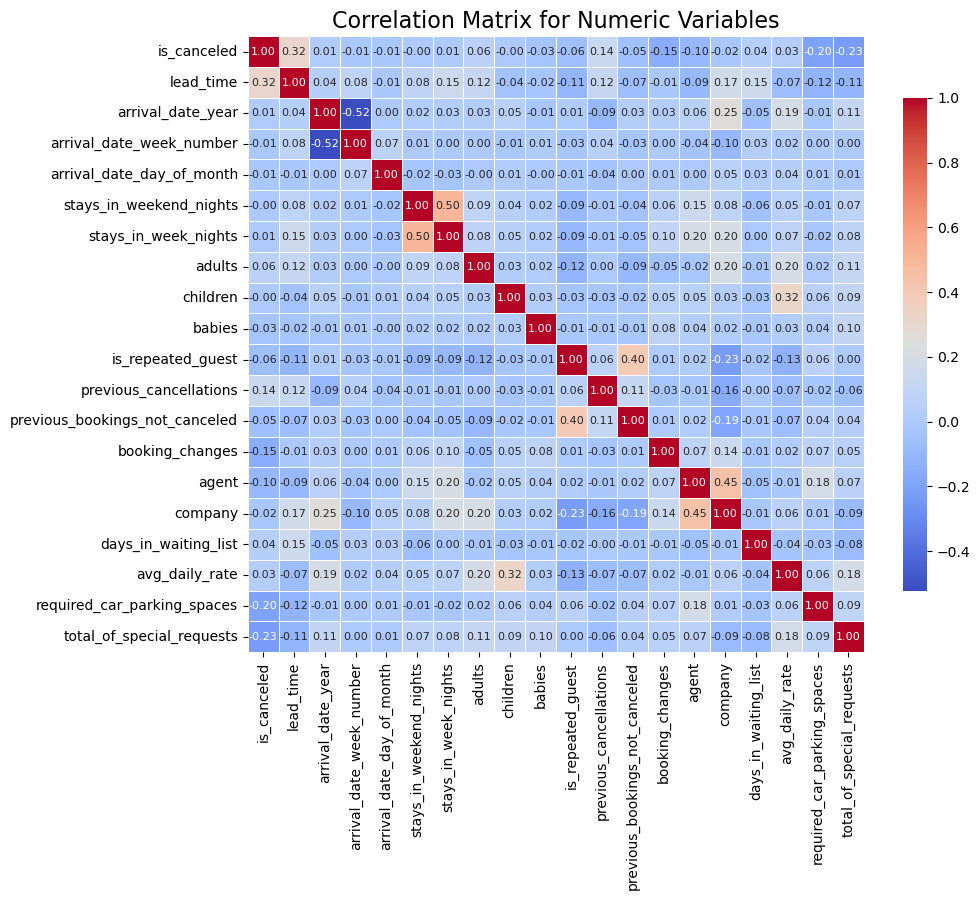

In [6]:
# numeric columns only
numeric_df = df.select_dtypes(include=['number'])

# compute correlation
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8)) 

# create heatmap
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='coolwarm', 
            square=True,   
            cbar_kws={"shrink": .8},  
            annot_kws={"size": 8}, 
            linewidths=0.5,      
            linecolor='white')   

plt.title('Correlation Matrix for Numeric Variables', fontsize=16) 
plt.show()

Based on the heatmap generated above, we can infer that the variables with the highest correlation with the variable "is_canceled" are lead_time, previous_cancellations, adults, days_in_waiting_list and avg_daily_rate

<strong><br/>
Data Engineering

In [7]:
# one-hot encoding for the categorical columns
df_encoded = pd.get_dummies(df, columns=['deposit_type', 'customer_type'])

# convert the specific one-hot encoded columns to integers
df_encoded[['deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'customer_type_Contract', 'customer_type_Group', 
            'customer_type_Transient', 'customer_type_Transient-Party']] = df_encoded[[
            'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'customer_type_Contract', 'customer_type_Group', 
            'customer_type_Transient', 'customer_type_Transient-Party']].astype(int)

<strong><br/>
Identifying features for model training and creating a KFold variable for all models

The features selected for the models will include the four most significant numeric variables identified from the correlation heat map, along with the two categorical features: deposit_type and customer_type

In [8]:
# features = ['lead_time', 'previous_cancellations', 'booking_changes', 'deposit_type_No Deposit', 'deposit_type_Non Refund',  'deposit_type_Refundable', 'customer_type_Contract', 'customer_type_Group', 'customer_type_Transient', 'customer_type_Transient-Party']
features = ['lead_time', 'previous_cancellations', 'days_in_waiting_list', 'avg_daily_rate', 'deposit_type_No Deposit', 'deposit_type_Non Refund',  'deposit_type_Refundable', 'customer_type_Contract', 'customer_type_Group', 'customer_type_Transient', 'customer_type_Transient-Party']
X = df_encoded[features]
y = df_encoded['is_canceled']

# create KFold variable for all models
kf = KFold(n_splits=5, shuffle=True, random_state=5)

<strong><br/>
Applying RainForestClassifier

In [9]:
RF_model = RandomForestClassifier(random_state=5, n_estimators=100)

RF_auc_scores = [] 

# perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit the model
    RF_model.fit(X_train, y_train)

    # predict probabilities on the validation set
    y_pred_proba = RF_model.predict_proba(X_test)[:, 1]

    # calculate AUC score for this fold
    RF_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    RF_auc_scores.append(RF_auc_score)

# print the AUC scores for each fold and the mean AUC
print("AUC scores for each fold:", RF_auc_scores)
print(f"Mean AUC for RainForestClassifier: {sum(RF_auc_scores) / len(RF_auc_scores)}")

AUC scores for each fold: [0.8833506094269961, 0.8856881278948305, 0.8862753257899367, 0.8880357997609925, 0.8823516934855258]
Mean AUC for RainForestClassifier: 0.8851403112716565


<strong><br/>
Applying Gradient Boosting Classifier

In [10]:
GB_model = GradientBoostingClassifier(learning_rate=0.01,random_state=5)

GB_auc_scores = [] 

# perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # fit the model
    GB_model.fit(X_train, y_train)

    # predict probabilities on the validation set
    y_pred_proba = GB_model.predict_proba(X_test)[:, 1]

    # calculate AUC score for this fold
    GB_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    GB_auc_scores.append(GB_auc_score)

# print the AUC scores for each fold and the mean AUC
print("AUC scores for each fold:", GB_auc_scores)
print(f"Mean AUC for GradientBoostingClassifier: {sum(GB_auc_scores) / len(GB_auc_scores)}")

AUC scores for each fold: [0.8022986692273307, 0.79910619402848, 0.8043366082332156, 0.8087990550860344, 0.805106637138771]
Mean AUC for GradientBoostingClassifier: 0.8039294327427664


<strong><br/>
Applying XGBClassifier

In [11]:
# define parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # binary classification for cancellations
    'learning_rate': 0.1,
    'random_state': 5,
    'eval_metric': 'auc'
}

XGB_auc_scores = []

# perform K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # create DMatrix for training and testing
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

    # train the model using xgb.train
    XGB_model = xgb.train(params, dtrain, num_boost_round=100)

    # predict probabilities on the validation set
    y_pred_proba = XGB_model.predict(dtest)

    # calculate AUC score for this fold
    XGB_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    XGB_auc_scores.append(XGB_auc_score)

# print the AUC scores for each fold and the mean AUC
print("AUC scores for each fold:", XGB_auc_scores)
print(f"Mean AUC for XGBoost: {sum(XGB_auc_scores) / len(XGB_auc_scores)}")

AUC scores for each fold: [0.8480603672124634, 0.8467935052913065, 0.8484139456203768, 0.8526357344560733, 0.848244319495908]
Mean AUC for XGBoost: 0.8488295744152256


<strong><br/>
Applying CatBoostClassifier

In [12]:
CB_model = CatBoostClassifier(learning_rate=0.1, random_state=5)

CB_features = ['lead_time', 'previous_cancellations', 'days_in_waiting_list', 'avg_daily_rate', 'deposit_type', 'customer_type']
CB_X = df[CB_features]
CB_y = df['is_canceled']

# set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=5)
CB_auc_scores = []  # List to store AUC scores for each fold

# perform K-Fold Cross-Validation
for train_index, test_index in kf.split(CB_X):
    X_train, X_test = CB_X.iloc[train_index], CB_X.iloc[test_index]
    y_train, y_test = CB_y.iloc[train_index], CB_y.iloc[test_index]

    # fit the model
    CB_model.fit(X_train, y_train, cat_features=['deposit_type', 'customer_type'], verbose=0)

    # predict probabilities on the validation set
    y_pred_proba = CB_model.predict_proba(X_test)[:, 1]

    # calculate AUC score for this fold
    CB_auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
    CB_auc_scores.append(CB_auc_score)

# print the AUC scores for each fold and the mean AUC
print("AUC scores for each fold:", CB_auc_scores)
print(f"Mean AUC: {sum(CB_auc_scores) / len(CB_auc_scores)}")

AUC scores for each fold: [0.8615013923610537, 0.8611773521909192, 0.8635332133043301, 0.8661249743463636, 0.8602122537379495]
Mean AUC: 0.8625098371881232


Since the RandomForestClassifier model achieved the highest AUC among all models, we will use it to predict cancellations.

<strong><br/>
Utilizing  test data for making predictions using the RandomForestClassifier model

In [13]:
file_path_for_testing = 'hotel_revenue_test_data.csv'

# Read the CSV file into a DataFrame
df_test = pd.read_csv(file_path_for_testing, header=0)

# one-hot encoding for the categorical columns
df_test_encoded = pd.get_dummies(df_test, columns=['deposit_type', 'customer_type'])

# convert the specific one-hot encoded columns to integers
df_test_encoded[['deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'customer_type_Contract', 'customer_type_Group', 
            'customer_type_Transient', 'customer_type_Transient-Party']] = df_encoded[[
            'deposit_type_No Deposit', 'deposit_type_Non Refund', 'deposit_type_Refundable',
            'customer_type_Contract', 'customer_type_Group', 
            'customer_type_Transient', 'customer_type_Transient-Party']].astype(int)

df_test

,booking id,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,avg_daily_rate,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,CH-001,City Hotel,NaN,12,2020,July,31,16,1,2,...,No Deposit,NaN,NaN,0,Transient,30.00,0,0,No-Show,7/16/2020
1,CH-002,City Hotel,NaN,23,2020,May,1,2,2,3,...,No Deposit,NaN,NaN,0,Transient,3.00,0,0,No-Show,5/6/2020
2,RH-001,Resort Hotel,NaN,34,2020,July,10,3,1,3,...,No Deposit,NaN,NaN,0,Transient,185.50,0,0,No-Show,7/17/2020
3,CH-003,City Hotel,NaN,46,2020,August,12,1,2,2,...,No Deposit,NaN,NaN,0,Transient,185.25,0,1,No-Show,8/2/2020


In [14]:
X = df_test_encoded[features]
y = df_test_encoded['is_canceled']

# make is_canceled predictions for new data
y_pred = RF_model.predict(df_test_encoded[features]) 
y_pred


results = []

for index, row in df_test_encoded.iterrows():
    booking_id = row['booking id']
    prediction = y_pred[index] 
    results.append(f"is_canceled prediction for {booking_id}: {prediction}")

# join all results into a string for display
results_string = "\n".join(results)

print(results_string)

is_canceled prediction for CH-001: 0
is_canceled prediction for CH-002: 1
is_canceled prediction for RH-001: 1
is_canceled prediction for CH-003: 0


<br/>
    
# Demand Forecasting for Bookings

<strong><br/>
Data Preprocessing

In [15]:
# convert month names to integers
df['arrival_date_month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month

df['arrival_date']= df['arrival_date_year'].astype(str) + df['arrival_date_month'].astype(str).str.zfill(2)+ df['arrival_date_day_of_month'].astype(str).str.zfill(2)
df['arrival_date'] = pd.to_datetime(df['arrival_date'], format='%Y%m%d')

In [16]:
# set 'arrival_date' as index
df.set_index('arrival_date', inplace=True)

<strong><br/>
Create lag features for the past 7 days for forecasting

In [17]:
# aggregate data to get number of bookings per date
daily_bookings = df.groupby(df.index.date).size()

# create df
daily_bookings_df = pd.DataFrame(daily_bookings, columns=['bookings'])
daily_bookings_df.index = pd.to_datetime(daily_bookings_df.index)
daily_bookings_df.to_csv('daily_bookings.csv', index=True)

# create lag features for the past 7 days
for i in range(1, 8):
    daily_bookings_df[f'lag_{i}'] = daily_bookings_df['bookings'].shift(i)

In [18]:
daily_bookings_df

,bookings,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
2018-07-01,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-02,93,122.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-03,56,93.0,122.0,NaN,NaN,NaN,NaN,NaN
2018-07-04,88,56.0,93.0,122.0,NaN,NaN,NaN,NaN
2018-07-05,53,88.0,56.0,93.0,122.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-08-26,166,191.0,156.0,126.0,98.0,159.0,159.0,188.0
2020-08-27,174,166.0,191.0,156.0,126.0,98.0,159.0,159.0
2020-08-28,336,174.0,166.0,191.0,156.0,126.0,98.0,159.0
2020-08-30,89,336.0,174.0,166.0,191.0,156.0,126.0,98.0


<strong><br/>
Developing the model using XGBRegressor and k-fold cross validation

In [19]:
X = daily_bookings_df.drop(columns=['bookings'])
y = daily_bookings_df['bookings']

mae_scores = []  

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

print("Mean Absolute Error for each fold:", mae_scores)
print(f"Mean MAE across all folds: {sum(mae_scores) / len(mae_scores)}")


Mean Absolute Error for each fold: [62.730809570907, 61.76772099036675, 59.12135357051701, 57.65402613122479, 55.30181418524848]
Mean MAE across all folds: 59.315144889652814


<strong></br>Now let's take a look at the scatter plot for actual vs predicted bookings

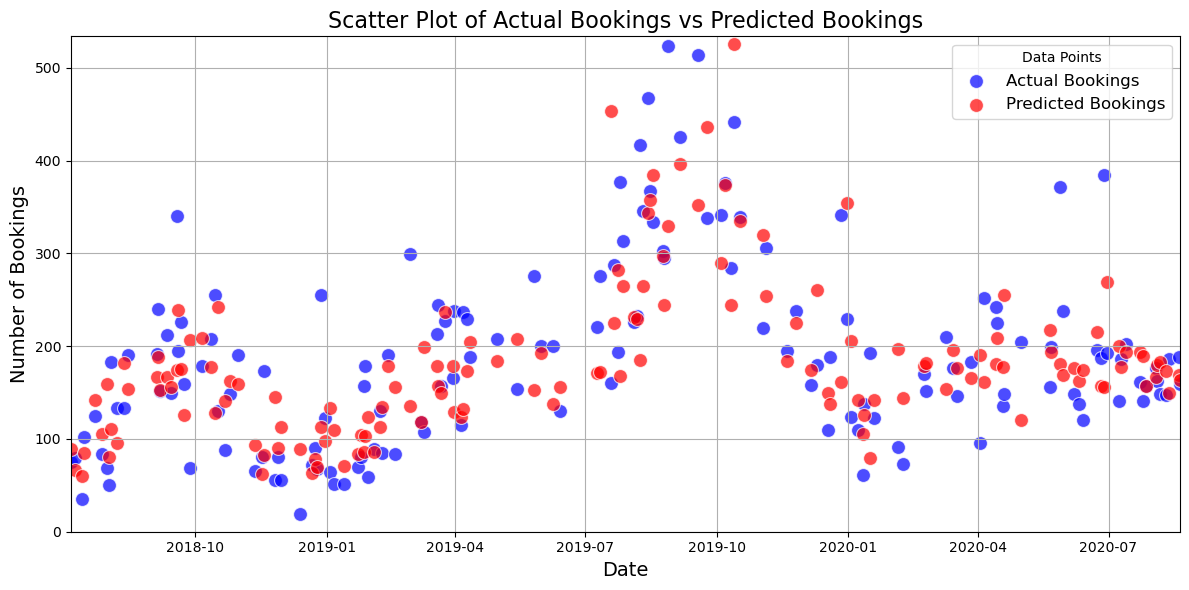

In [20]:
plt.figure(figsize=(12, 6))

df_plot = pd.DataFrame({
    'Date': y_test.index,
    'Actual Bookings': y_test,
    'Predicted Bookings': y_pred
})

sns.scatterplot(x='Date', y='Actual Bookings', data=df_plot, 
                s=100, color='blue', alpha=0.7, label='Actual Bookings')

sns.scatterplot(x='Date', y='Predicted Bookings', data=df_plot, 
                s=100, color='red', alpha=0.7, label='Predicted Bookings')

plt.title("Scatter Plot of Actual Bookings vs Predicted Bookings", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Number of Bookings", fontsize=14)

plt.xlim([y_test.index.min(), y_test.index.max()])
plt.ylim([0, max(y_test) + 10])

plt.grid(True)
plt.legend(title="Data Points", fontsize=12)
plt.tight_layout()
plt.show()

The scatter plot shows a strong alignment between the actual and predicted bookings.

<strong><br/>Let's look at predictions for the first 8 days after 31 Aug 2020

In [21]:
file_path_for_testing = 'daily_bookings_forecast_test.csv'

df_test = pd.read_csv(file_path_for_testing, header=0)
df_test = df_test.set_index('Unnamed: 0')

# create lag features for the past 7 days
for i in range(1, 8):
    df_test[f'lag_{i}'] = df_test['bookings'].shift(i)

X = df_test[[f'lag_{i}' for i in range(1, 8)]]
y = df_test['bookings']

forecast_predictions = model.predict(X).round(0).astype(int)

forecast_results = pd.DataFrame({'Date': df_test.index, 'Predicted Bookings': forecast_predictions})
print(forecast_results.tail(8))


           Date  Predicted Bookings
768  2020-09-01                 128
769  2020-09-02                 188
770  2020-09-03                 206
771  2020-09-04                 278
772  2020-09-05                 160
773  2020-09-06                 127
774  2020-09-07                 181
775  2020-09-08                 120
